<a href="https://colab.research.google.com/github/muratgorgl/Camouflage-Detection-Project/blob/main/Camouflage_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers

In [ ]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
# Eğitim ve test veri dizinleri
train_dir = "/gdrive/MyDrive/Kamuflaj_Project/dataset-splitM/Training"
test_dir = "/gdrive/MyDrive/Kamuflaj_Project/dataset-splitM/Testing"

In [ ]:
# ImageDataGenerator ile veri artırma ve ön işleme
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Verilerin yüklenmesi
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [ ]:
# CNN Modeli Oluşturma
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_100 (Conv2D)                  │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_100 (MaxPooling2D)     │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_101 (MaxPooling2D)     │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_102 (MaxPooling2D)     │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,838,721 (18.46 MB)

 Trainable params: 4,838,721 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Modeli Derleme
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks Tanımlama
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Modeli Eğitme
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[reduce_lr, early_stopping],
    verbose=True
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5264 - loss: 0.6939 - val_accuracy: 0.5677 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4531 - loss: 0.6918 - val_accuracy: 0.5345 - val_loss: 0.6860 - learning_rate: 1.0000e-04
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 930ms/step - accuracy: 0.6289 - loss: 0.6568 - val_accuracy: 0.5729 - val_loss: 0.6792 - learning_rate: 1.0000e-04
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7656 - loss: 0.5343 - val_accuracy: 0.6379 - val_loss: 0.6384 - learning_rate: 1.0000e-04
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7457 - loss: 0.5640 - val_accuracy: 0.6875 - val_loss: 0.5996 - learning_rate: 1.0000e-04
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7500 - loss: 0.5609 - val_accuracy: 0.6207 - val_loss: 0.6675 - learning_rate: 1.0000e-04
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 924ms/step - accuracy: 0.798

In [ ]:

# Modeli değerlendirme
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 695ms/step - accuracy: 0.6569 - loss: 0.5815
Test Loss: 0.5902531743049622
Test Accuracy: 0.6614583134651184


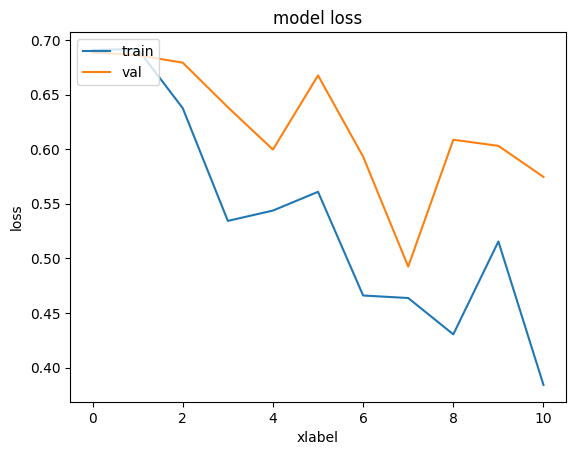

In [ ]:

from matplotlib import pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")

plt.ylabel("loss")
plt.xlabel("xlabel")
plt.legend(["train","val"],loc="upper left")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step


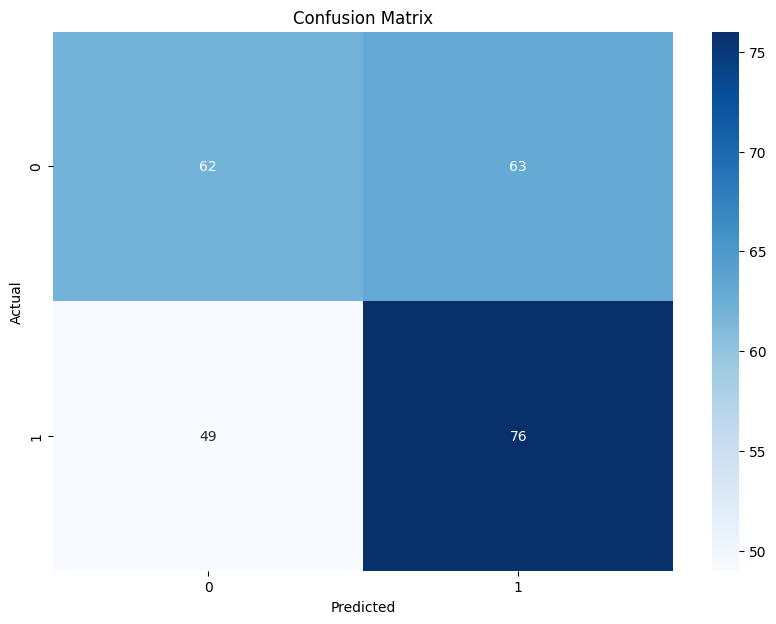

              precision    recall  f1-score   support

      Normal       0.56      0.50      0.53       125
    Kamuflaj       0.55      0.61      0.58       125

    accuracy                           0.55       250
   macro avg       0.55      0.55      0.55       250
weighted avg       0.55      0.55      0.55       250



In [ ]:
import numpy as np

# Tahminleri al
Y_pred = model.predict(validation_generator)
y_pred = np.round(Y_pred).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Gerçek etiketleri al
y_true = validation_generator.classes

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Görselleştir
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=['Normal', 'Kamuflaj']))
